In [1]:
import os
import random
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds # used for tfds.as_numpy()
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Activation

2024-02-04 07:59:07.592862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-04 07:59:07.592965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-04 07:59:07.728589: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
seed = 42

tf.random.set_seed(seed=42)

## Classes:
- 0 = background
- 1 = car
- 2 = wheel
- 3 = lights
- 4 = window


# Processing

In [3]:
IMG_HEIGHT = 512
IMG_WIDTH = 1024
BATCH_SIZE = 8

val_split = 0.2
n_classes = 5
class_names = ["background", "car", "wheel", "lights", "window"]

In [4]:
def parse_image_and_mask(image_path, mask_path):
    # Load the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = tf.cast(image, tf.int64) # (IMG_HEIGHT, IMG_WIDTH, 3)

    # Load the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.one_hot(tf.cast(mask, tf.int32), depth=n_classes)  # Depth is 5 for classes 0 to 4
    mask = tf.squeeze(mask, -2) # (IMG_HEIGHT, IMG_WIDTH, n_classes)

    return image, mask

def create_dataset(image_paths, mask_paths):
    # Create a dataset of image and mask paths
    path_dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))

    # Load and preprocess images and masks
    dataset = path_dataset.map(parse_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

# Get paths of all images and masks
root = "/kaggle/input/car-segmentation/car-segmentation/"
image_paths = sorted(glob(os.path.join(root, "images/*")))
mask_paths = sorted(glob(os.path.join(root, "masks/*")))

# Create the dataset
dataset = create_dataset(image_paths, mask_paths)

In [5]:
def plot_example(image, mask, pred=None):
    plt.figure(figsize=(20, 10))
    ncols = n_classes
    nrows = 2 if pred is None else 3
    
    # plot image
    plt.subplot(nrows, ncols, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis("off")
    
    # plot each channel in mask
    for i in range(n_classes):
        mask_channel = mask[:, :, i]
        plt.subplot(nrows, ncols, i+n_classes+1)
        plt.imshow(mask_channel)
        plt.title(f"Mask, {class_names[i]}")
        plt.axis("off")
        
    # plot each channel in prediction
    if pred is not None:
        for i in range(n_classes):
            mask_channel = pred[:, :, i] 
            plt.subplot(nrows, ncols, i+n_classes*2+1)
            plt.imshow(mask_channel)
            plt.title(f"Prediction, {class_names[i]}")
            plt.axis("off")

    plt.tight_layout()
    plt.show()

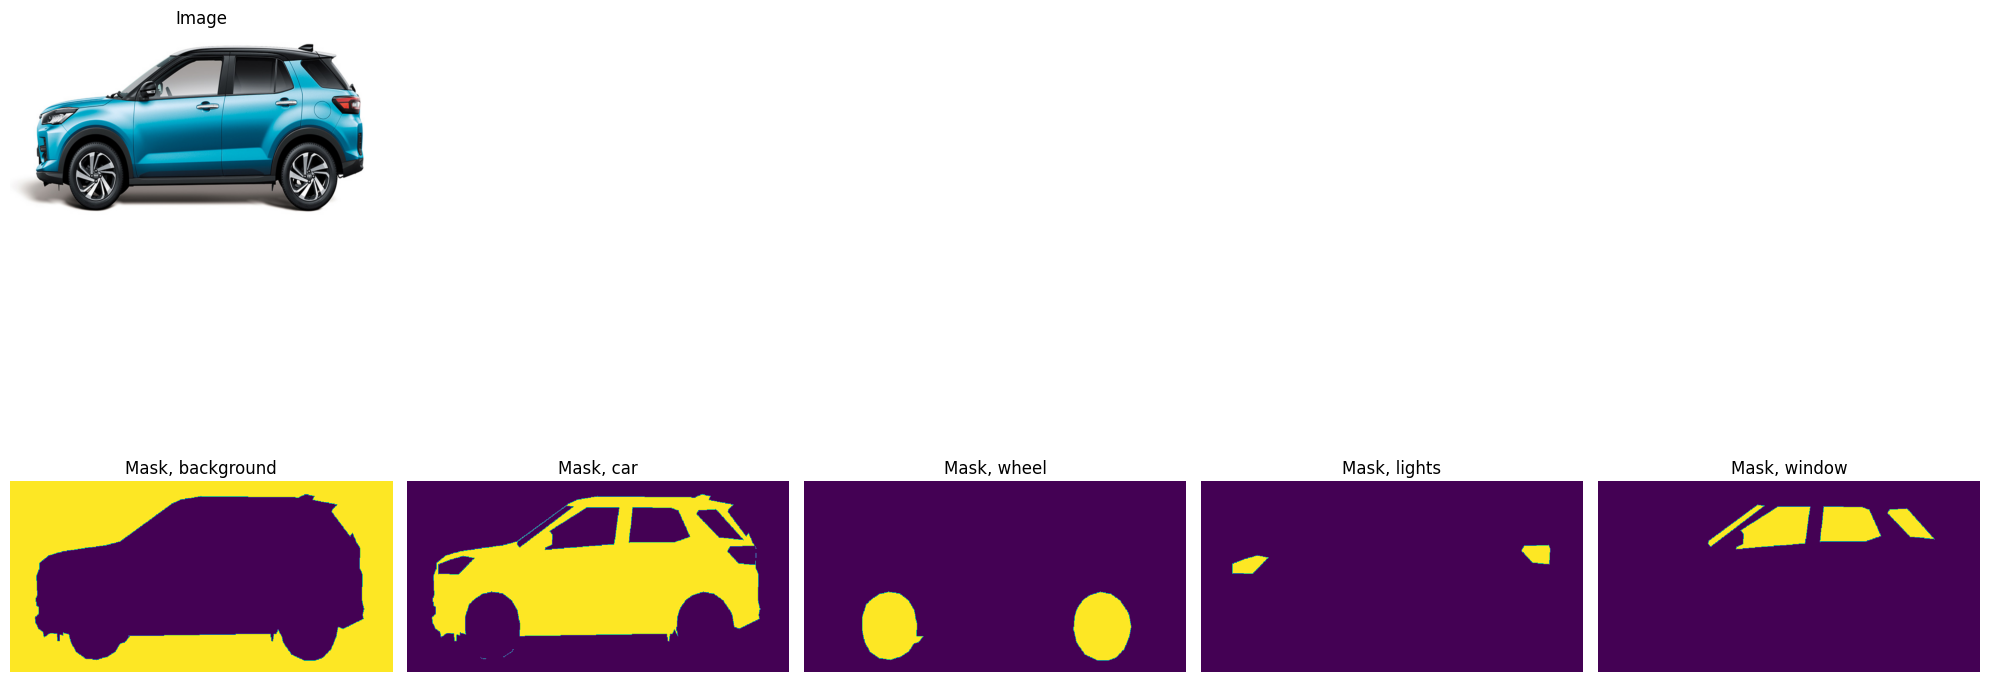

In [6]:
image, mask = next(iter(dataset))
plot_example(image, mask)

In [7]:
n = len(dataset)
val_n = int(val_split*n)
print(f"Training N: {n-val_n}")
print(f"Validation N: {val_n}")

# shuffle dataset
dataset = dataset.shuffle(1000, seed=seed)

# split into train and validation
train_ds = dataset.skip(val_n)
val_ds = dataset.take(val_n)

# shuffle, cache, batch and prefetch (for efficient data loading)
train_ds = train_ds.shuffle(buffer_size=1000, seed=seed) \
                   .cache() \
                   .batch(batch_size=BATCH_SIZE) \
                   .prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.batch(batch_size=BATCH_SIZE) \
               .cache() \
               .prefetch(buffer_size=tf.data.AUTOTUNE)

Training N: 169
Validation N: 42


In [8]:
# example batch
ib, mb = next(iter(train_ds))
ib.shape, mb.shape

(TensorShape([8, 512, 1024, 3]), TensorShape([8, 512, 1024, 5]))

# Inference (load trained model)

In [9]:
# new_model = tf.keras.models.load_model('/kaggle/input/car-segmentation-model/model.keras')

# # test on some validation data
# imageb, maskb = next(iter(val_ds))

# for i in range(len(imageb)):
#     image, mask = imageb[i], maskb[i]

#     pred = new_model.predict(image[tf.newaxis, ...])[0] # (height, width, n_classes) , in probabilities
#     pred = tf.math.argmax(pred, axis=-1) # (height, width) , in classes [0, 1, 2, 3, 4,...]
#     pred = tf.cast(tf.one_hot(pred, depth=n_classes), tf.int64) # (height, width, n_classes) , in one hot [0, 0, 0, 0, 1], [0, 1, 0, 0, 0] ...

#     plot_example(image, mask, pred)

# Class weights

In [10]:
# get masks from training dataset
train_masks = tfds.as_numpy(train_ds.map(lambda img, mask: mask))

class_weights_agg = []

# compute class weights for each batch
for i, batch in enumerate(train_masks): # batch: # (batch_size, height, width, n_classes)
    print(f"Processing batch: {i+1}/{len(train_masks)}")
    batch = tf.math.argmax(batch, axis=-1) # (batch_size, height, width) , contains class labels [0, 1, 2, 3, 4,...]
    ys = tf.cast(tf.reshape(batch, -1), tf.int32) # flatten

    # compute class weights based as inverse frequency of each class label, lower frequency means higher weight
    class_weights = compute_class_weight(class_weight="balanced", classes=list(range(n_classes)), y=ys.numpy())
    class_weights_agg.append(class_weights)

class_weights = np.array(class_weights_agg).mean(axis=0)
print(f"Class weights: {class_weights}")
print({class_names[i]: class_weights[i] for i in range(n_classes)})

Processing batch: 1/22
Processing batch: 2/22
Processing batch: 3/22
Processing batch: 4/22
Processing batch: 5/22
Processing batch: 6/22
Processing batch: 7/22
Processing batch: 8/22
Processing batch: 9/22
Processing batch: 10/22
Processing batch: 11/22
Processing batch: 12/22
Processing batch: 13/22
Processing batch: 14/22
Processing batch: 15/22
Processing batch: 16/22
Processing batch: 17/22
Processing batch: 18/22
Processing batch: 19/22
Processing batch: 20/22
Processing batch: 21/22
Processing batch: 22/22
Class weights: [ 0.30734031  0.87846754  3.93591634 49.69934773  5.76932388]
{'background': 0.30734030692681324, 'car': 0.8784675369669259, 'wheel': 3.9359163400349146, 'lights': 49.69934772513879, 'window': 5.769323875814869}


# Segmentation model

In [11]:
def conv_block(x, n_filters, dropout, l2):
    """conv -> batchnorm -> relu -> dropout -> conv -> batchnorm -> relu"""
    # conv layers use_bias=False because batchnorm maintains its own bias
    x = Conv2D(n_filters, (3, 3), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2))(x) 
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(dropout)(x)
    x = Conv2D(n_filters, (3, 3), padding='same', use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(l2))(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def encoder_block(x, n_filters, dropout, l2):
    """conv block and pooling"""
    x = conv_block(x, n_filters, dropout, l2)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(x, p, n_filters, dropout, l2):
    """upsample, skip connection, and conv block"""
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2))(x)
    x = concatenate([x, p])
    x = conv_block(x, n_filters, dropout, l2)
    return x

def multi_unet_model(n_classes, img_height, img_width, img_channels):
    inputs = Input((img_height, img_width, img_channels))
    s = inputs
    
    # Contraction path, encoder
    c1, p1 = encoder_block(inputs, n_filters=16, dropout=0, l2=0.0001)
    c2, p2 = encoder_block(p1, n_filters=32, dropout=0, l2=0.0001)
    c3, p3 = encoder_block(p2, n_filters=64, dropout=0, l2=0.0001)
    c4, p4 = encoder_block(p3, n_filters=128, dropout=0, l2=0.001)
    c5, p5 = encoder_block(p4, n_filters=256, dropout=0, l2=0.001)
    c6, p6 = encoder_block(p5, n_filters=512, dropout=0, l2=0.01)

    # Bottleneck
    bridge = conv_block(p6, n_filters=1024, dropout=0, l2=0.01)
    
    # Expansive path, decoder
    u6 = decoder_block(bridge, c6, n_filters=512, dropout=0, l2=0.01)
    u5 = decoder_block(u6, c5, n_filters=256, dropout=0, l2=0.001)
    u4 = decoder_block(u5, c4, n_filters=128, dropout=0, l2=0.001)
    u3 = decoder_block(u4, c3, n_filters=64, dropout=0, l2=0.0001)
    u2 = decoder_block(u3, c2, n_filters=32, dropout=0, l2=0.0001)
    u1 = decoder_block(u2, c1, n_filters=16, dropout=0, l2=0.0001)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [12]:
unet_model = multi_unet_model(n_classes=5, img_height=IMG_HEIGHT, img_width=IMG_WIDTH, img_channels=3)

print(f"Input shape: {unet_model.input_shape}")
print(f"Output shape: {unet_model.output_shape}")
print(f"Trainable params: {np.sum([np.prod(v.get_shape()) for v in unet_model.trainable_variables])}")

Input shape: (None, 512, 1024, 3)
Output shape: (None, 512, 1024, 5)
Trainable params: 31116149


# Training

In [13]:
# hyperparams
EPOCHS = 500

# instantiate model
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    unet_model,
])

# learning rate schedule
starter_learning_rate = 1e-4
end_learning_rate = 1e-6
decay_steps = len(train_ds) * 400
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

# optimizer
opt = tf.keras.optimizers.Adam(learning_rate_fn)

# loss
cce = tf.keras.losses.CategoricalFocalCrossentropy(
    alpha=class_weights, gamma=2, 
) # focal loss is essentially crossentropy with extra emphasis on minority classes

# compile
model.compile(
    optimizer=opt, loss=cce, metrics=["accuracy"]
)
print(f"Expected initial loss (only valid if weight regularization is not being applied): {-np.log(1/n_classes)}")

# save checkpoints
checkpoint_path = "training_2/model.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_freq='epoch',
)]

# train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
)

Expected initial loss (only valid if weight regularization is not being applied): 1.6094379124341003
Epoch 1/500


I0000 00:00:1707033624.101011      67 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 [==============================] - 61s 1s/step - loss: 42.5217 - accuracy: 0.1244 - val_loss: 35.8550 - val_accuracy: 0.0697
Epoch 2/500
22/22 [==============================] - 12s 530ms/step - loss: 31.7827 - accuracy: 0.1243 - val_loss: 26.8312 - val_accuracy: 0.0795
Epoch 3/500
22/22 [==============================] - 12s 532ms/step - loss: 23.6795 - accuracy: 0.1232 - val_loss: 20.0987 - val_accuracy: 0.0917
Epoch 4/500
22/22 [==============================] - 12s 536ms/step - loss: 17.6715 - accuracy: 0.1364 - val_loss: 15.2143 - val_accuracy: 0.1111
Epoch 5/500
22/22 [==============================] - 12s 532ms/step - loss: 13.3461 - accuracy: 0.1702 - val_loss: 11.6573 - val_accuracy: 0.1354
Epoch 6/500
22/22 [==============================] - 12s 538ms/step - loss: 10.1552 - accuracy: 0.2013 - val_loss: 9.0239 - val_accuracy: 0.1623
Epoch 7/500
22/22 [==============================] - 13s 581ms/step - loss: 7.7665 - accuracy: 0.2329 - val_loss: 7.1034 - val_accuracy: 0.1

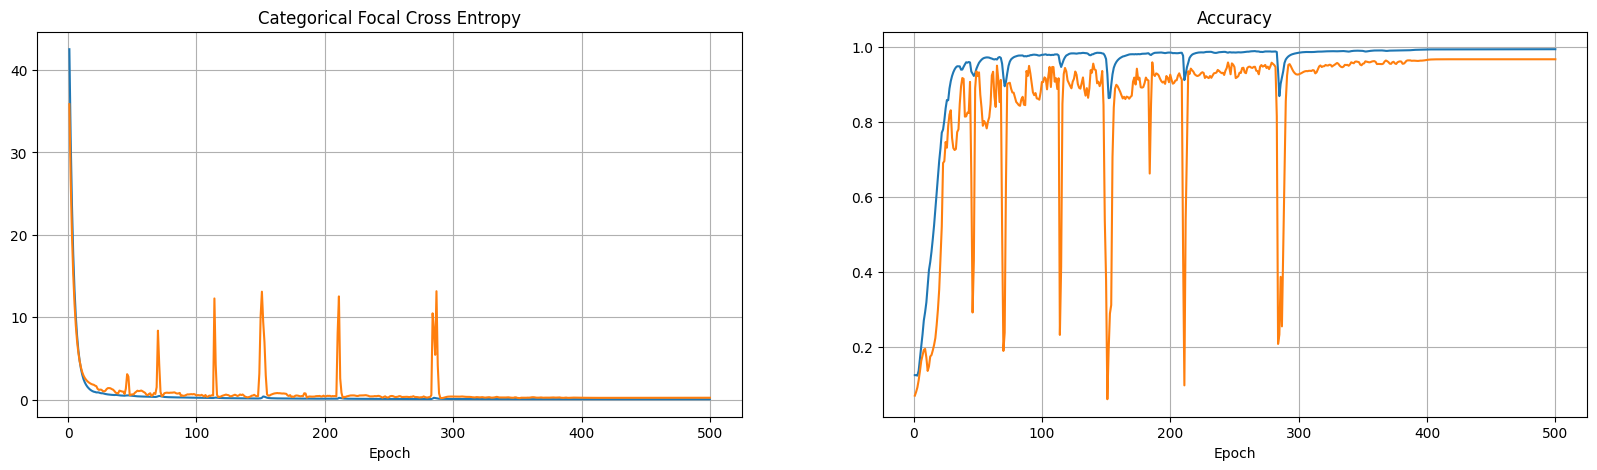

In [14]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(loss)+1)

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, label="Training loss")
plt.plot(epochs, val_loss, label="Validation loss")
plt.title("Categorical Focal Cross Entropy")
plt.xlabel("Epoch")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.grid(True)

# Evaluation

In [15]:
train_loss = model.evaluate(train_ds)[0]
val_loss = model.evaluate(val_ds)[0]

print(f"Final training loss: {train_loss}")
print(f"Final validation loss: {val_loss}")

6/6 [==============================] - 1s 121ms/step - loss: 0.2436 - accuracy: 0.9670
Final training loss: 0.19066283106803894
Final validation loss: 0.24361376464366913


1/1 [==============================] - 1s 539ms/step


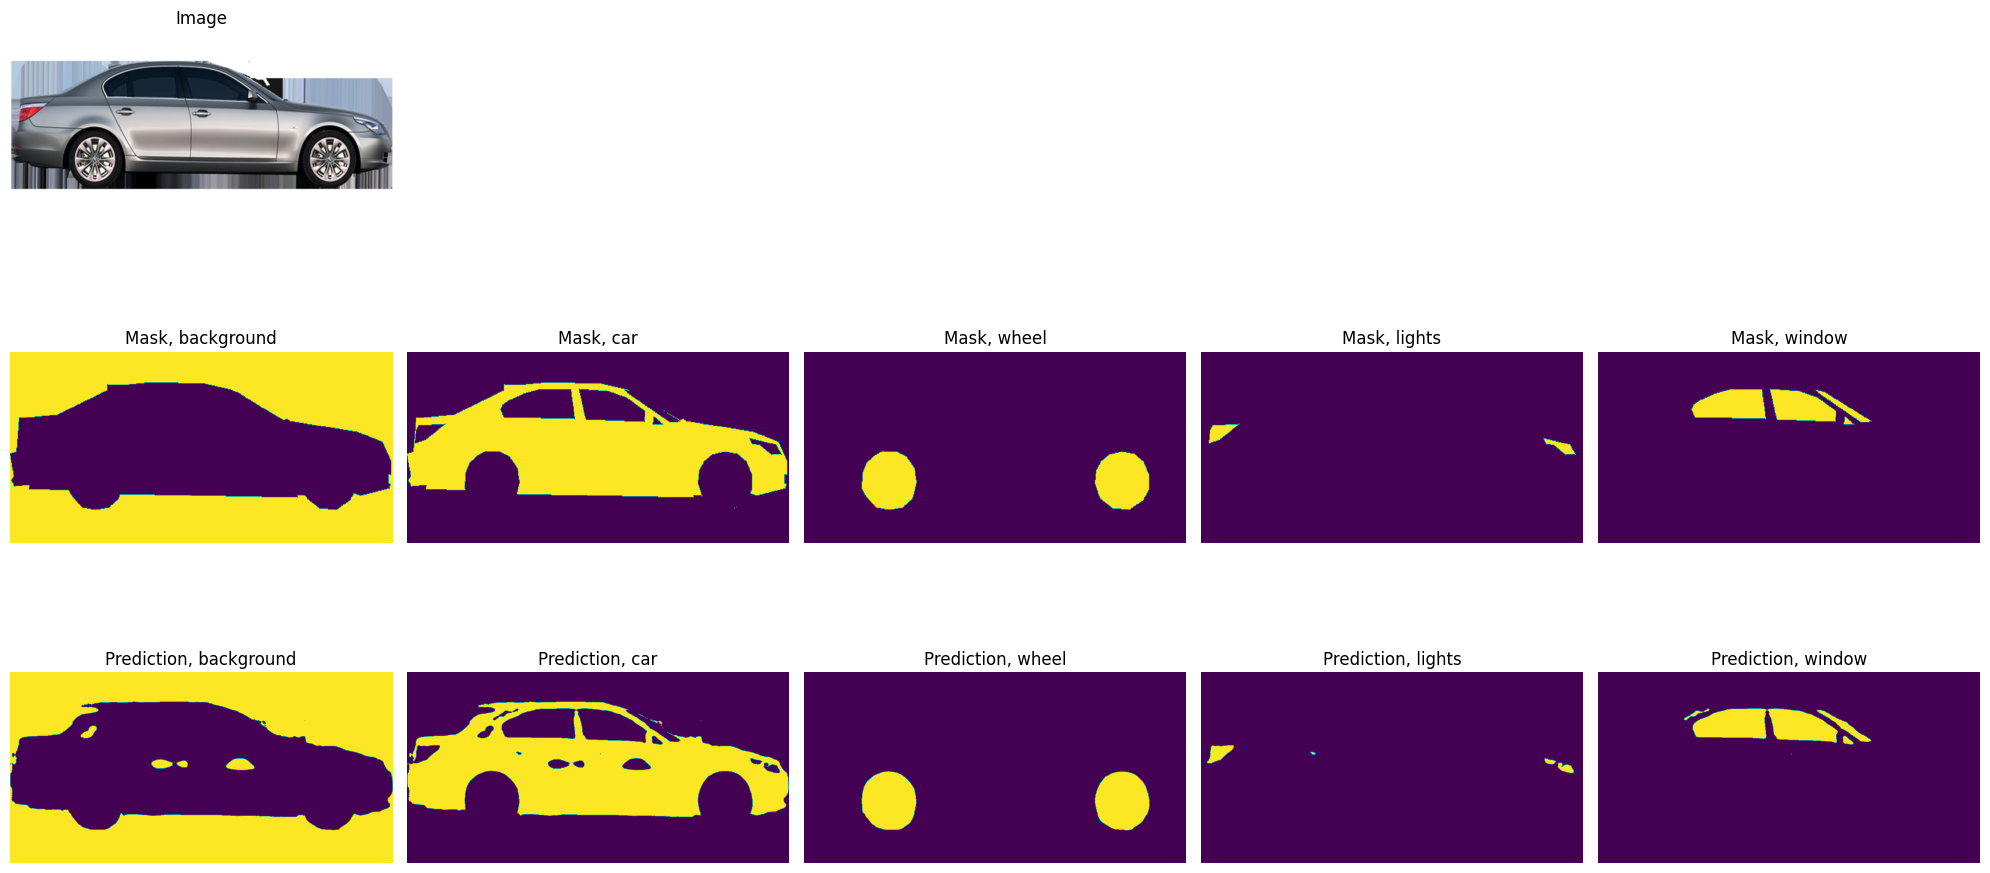

1/1 [==============================] - 0s 40ms/step


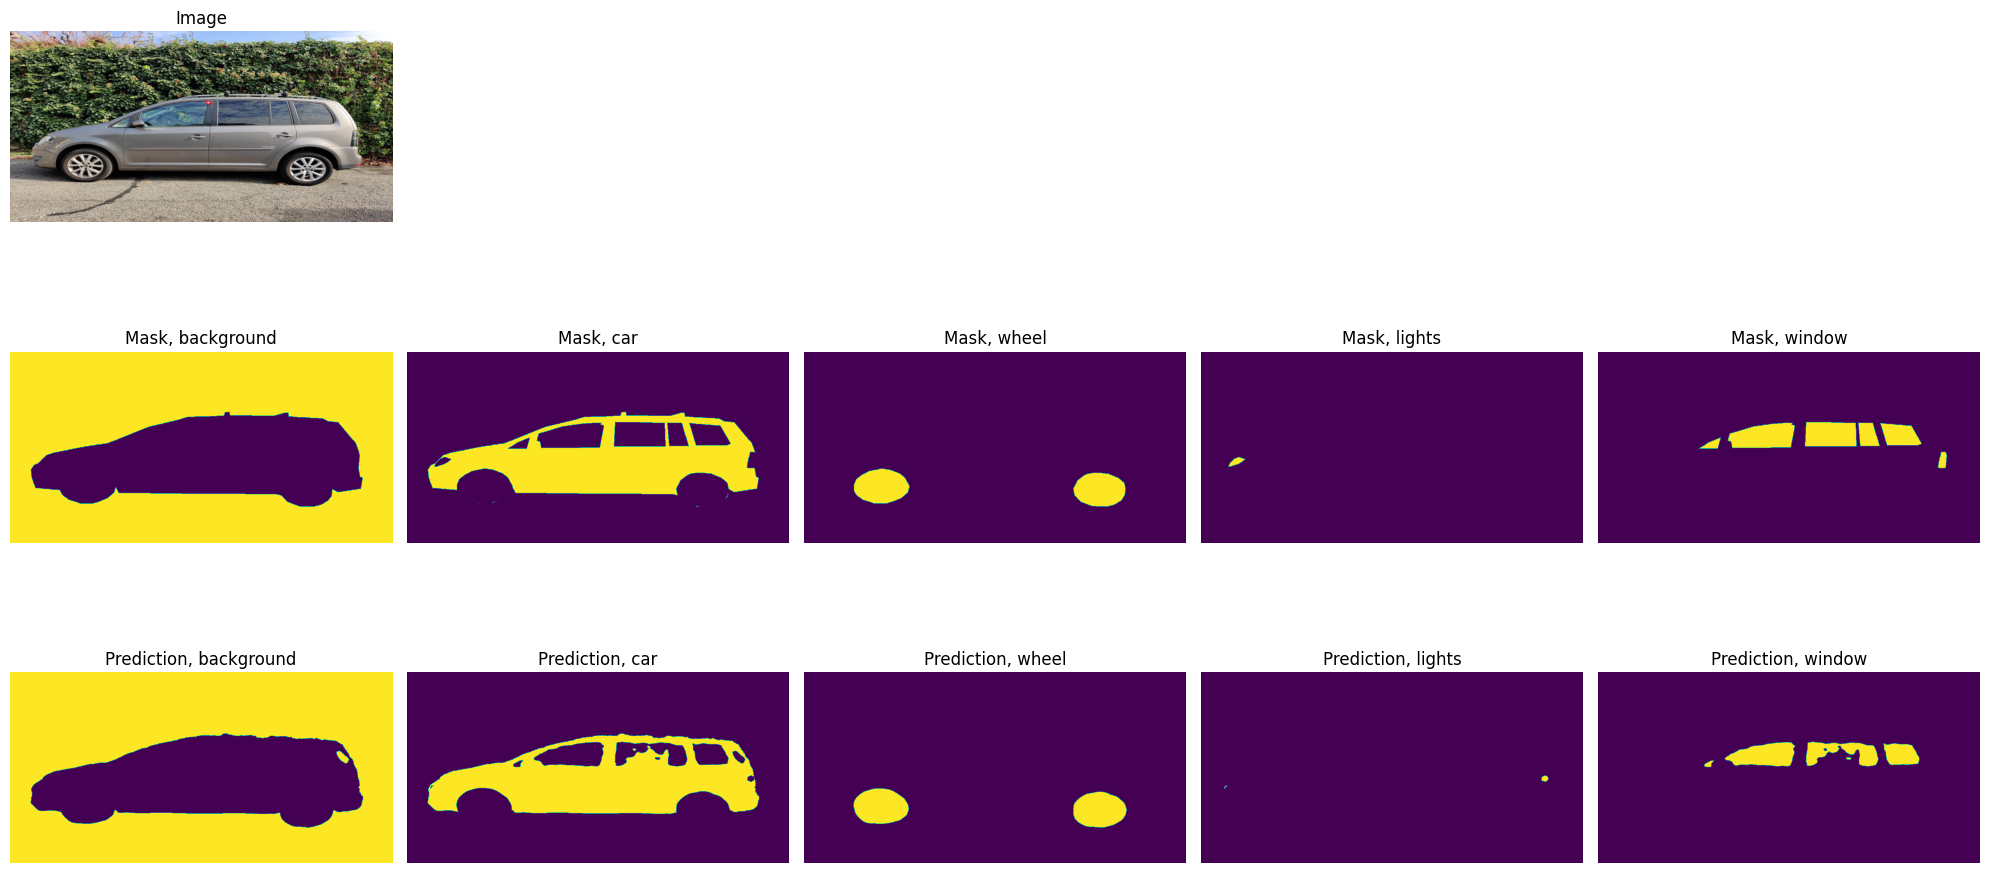

1/1 [==============================] - 0s 26ms/step


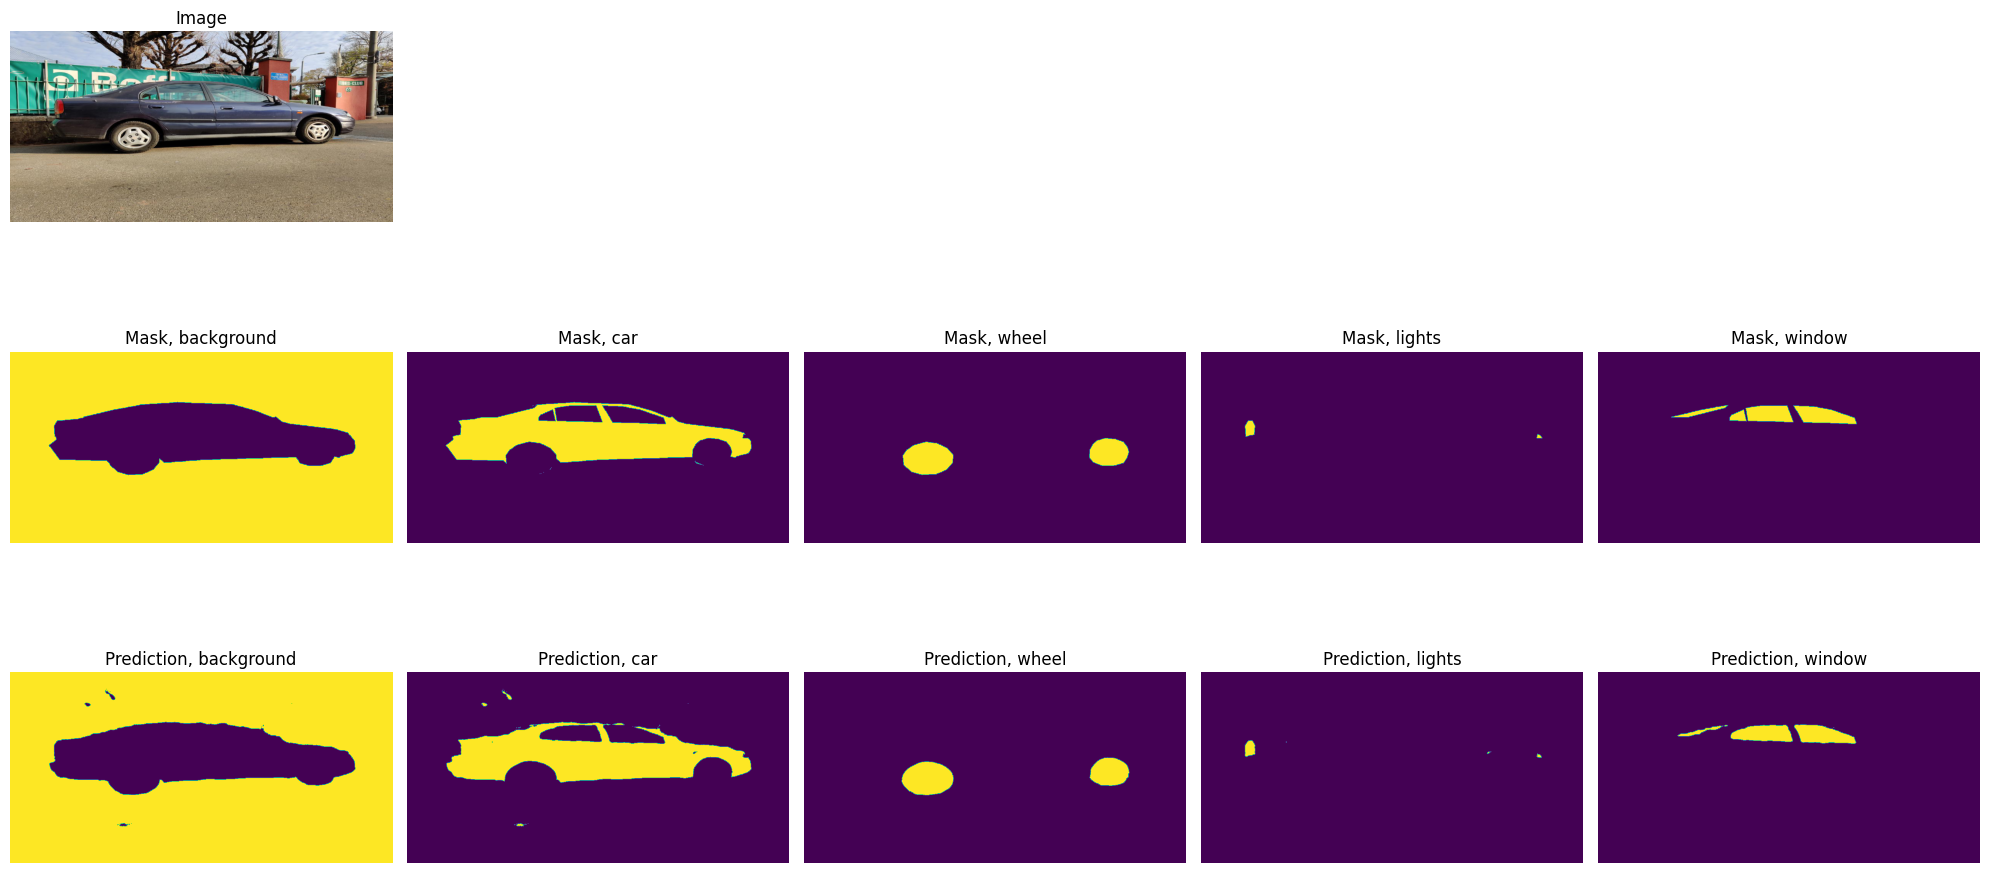

1/1 [==============================] - 0s 33ms/step


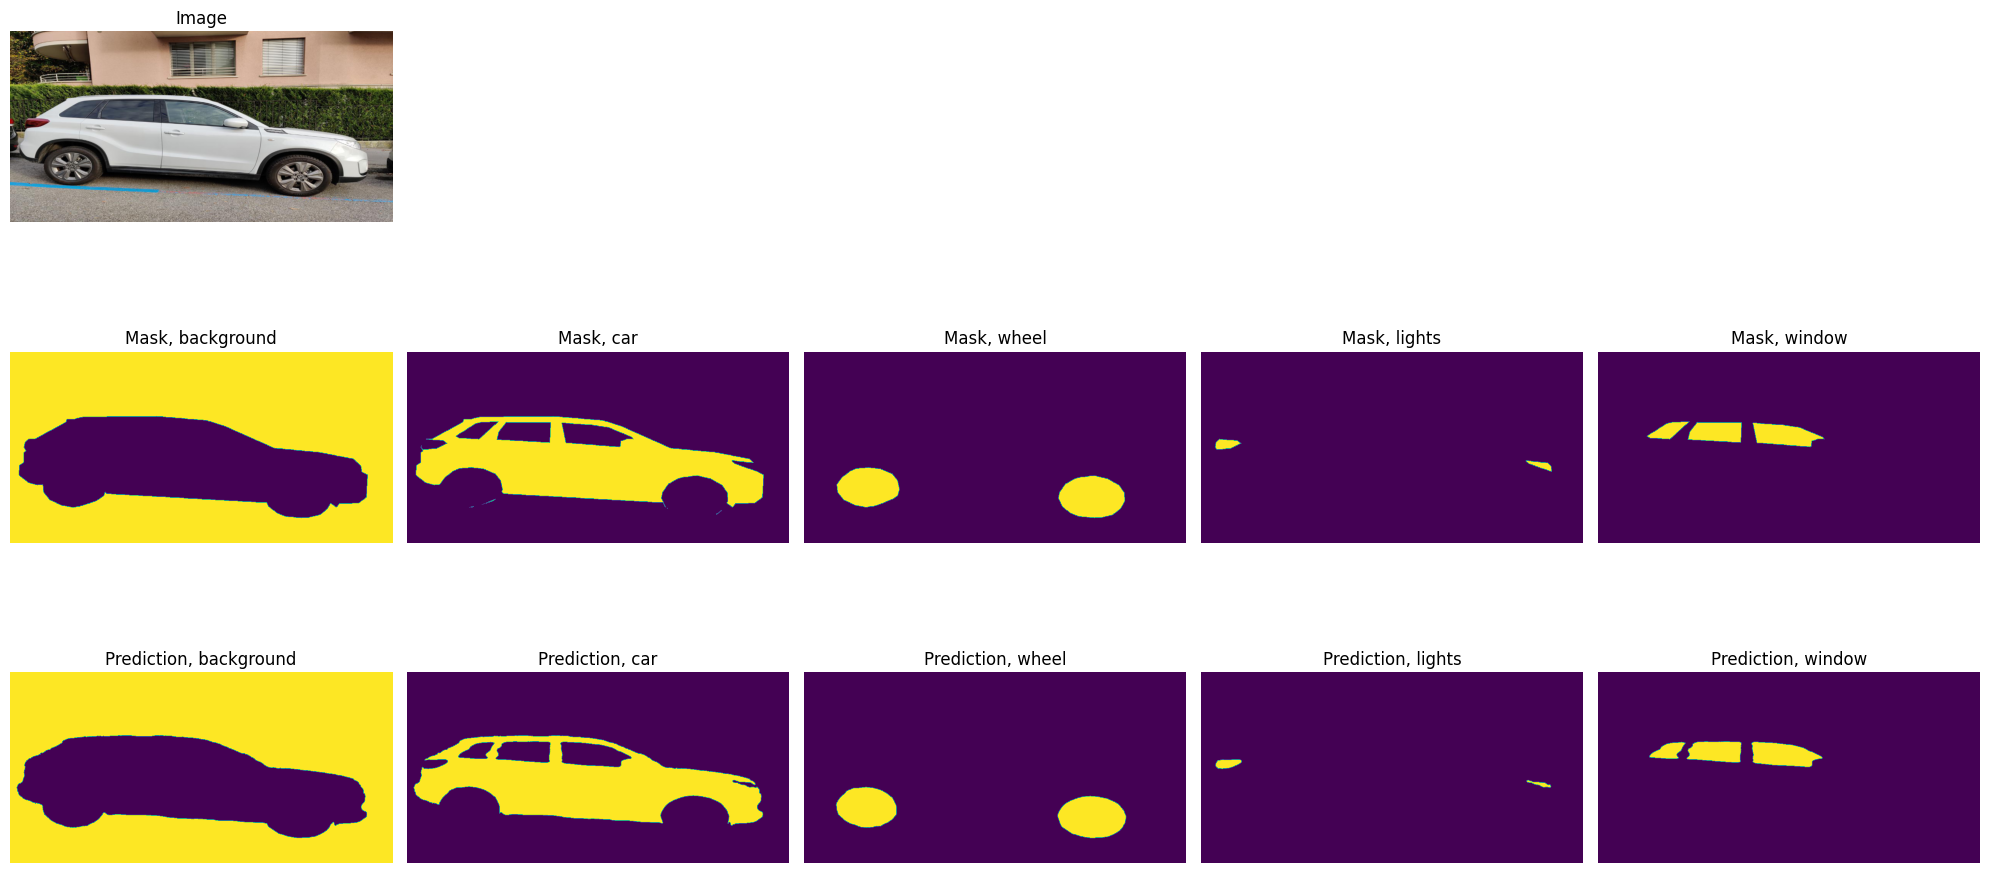

1/1 [==============================] - 0s 32ms/step


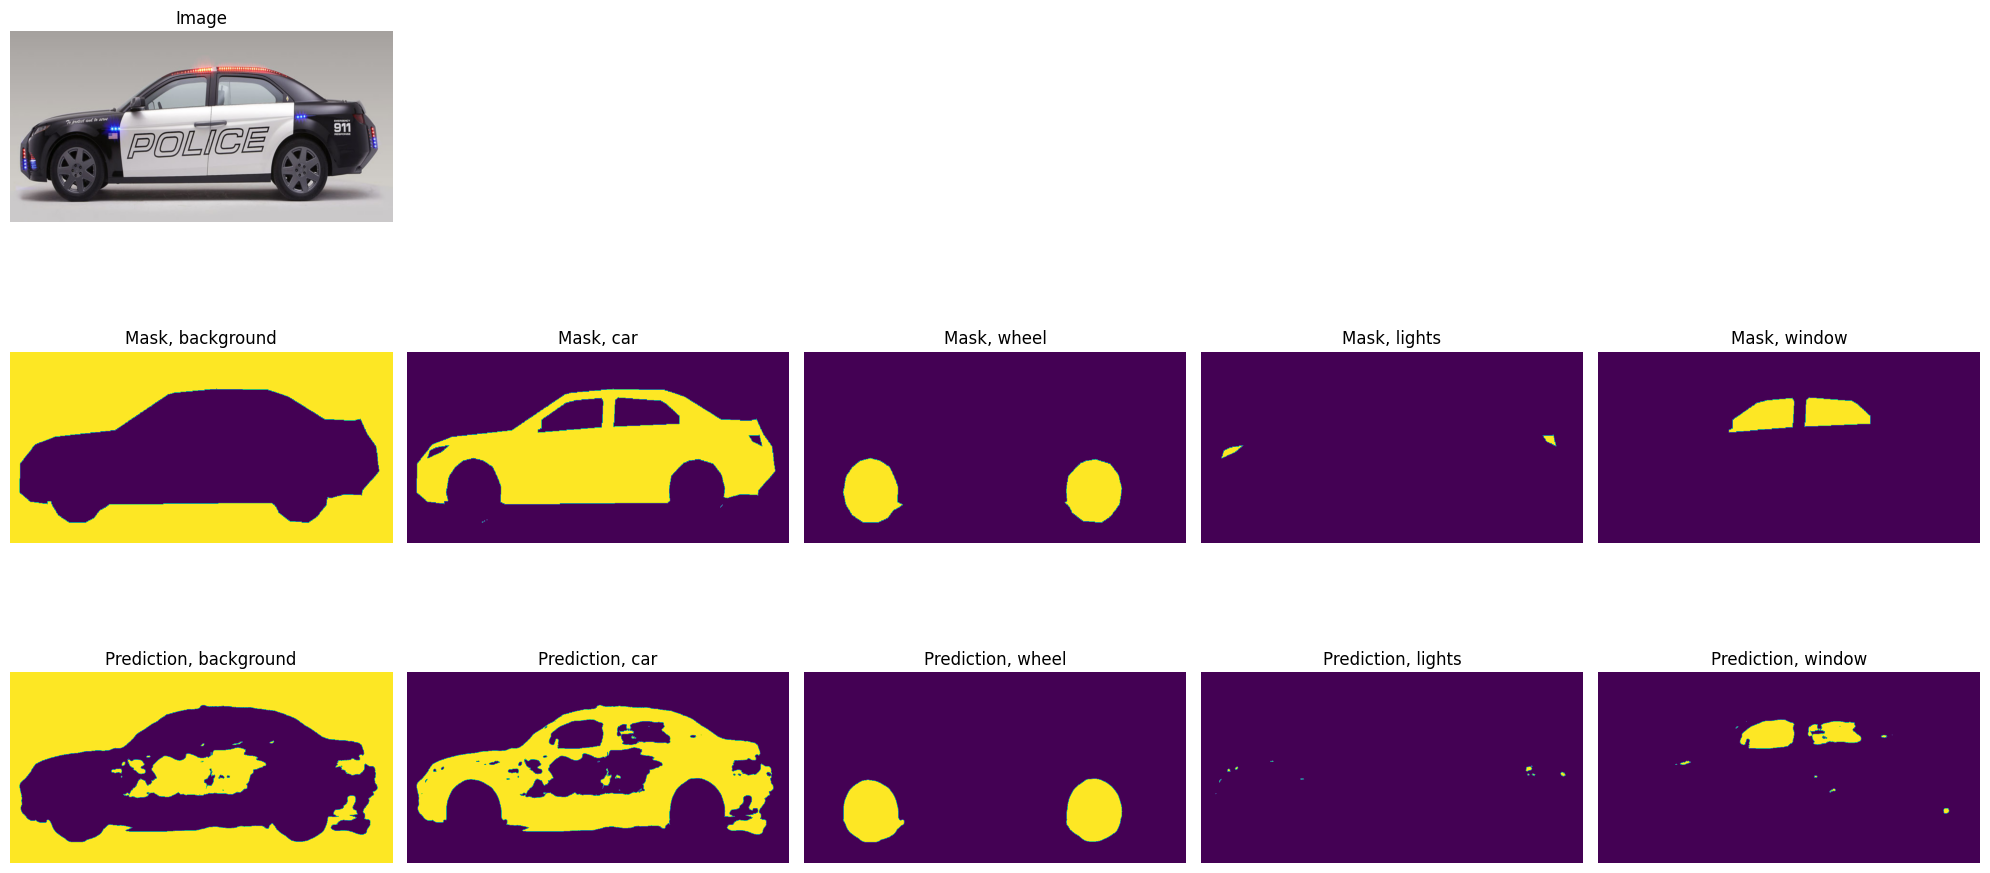

1/1 [==============================] - 0s 26ms/step


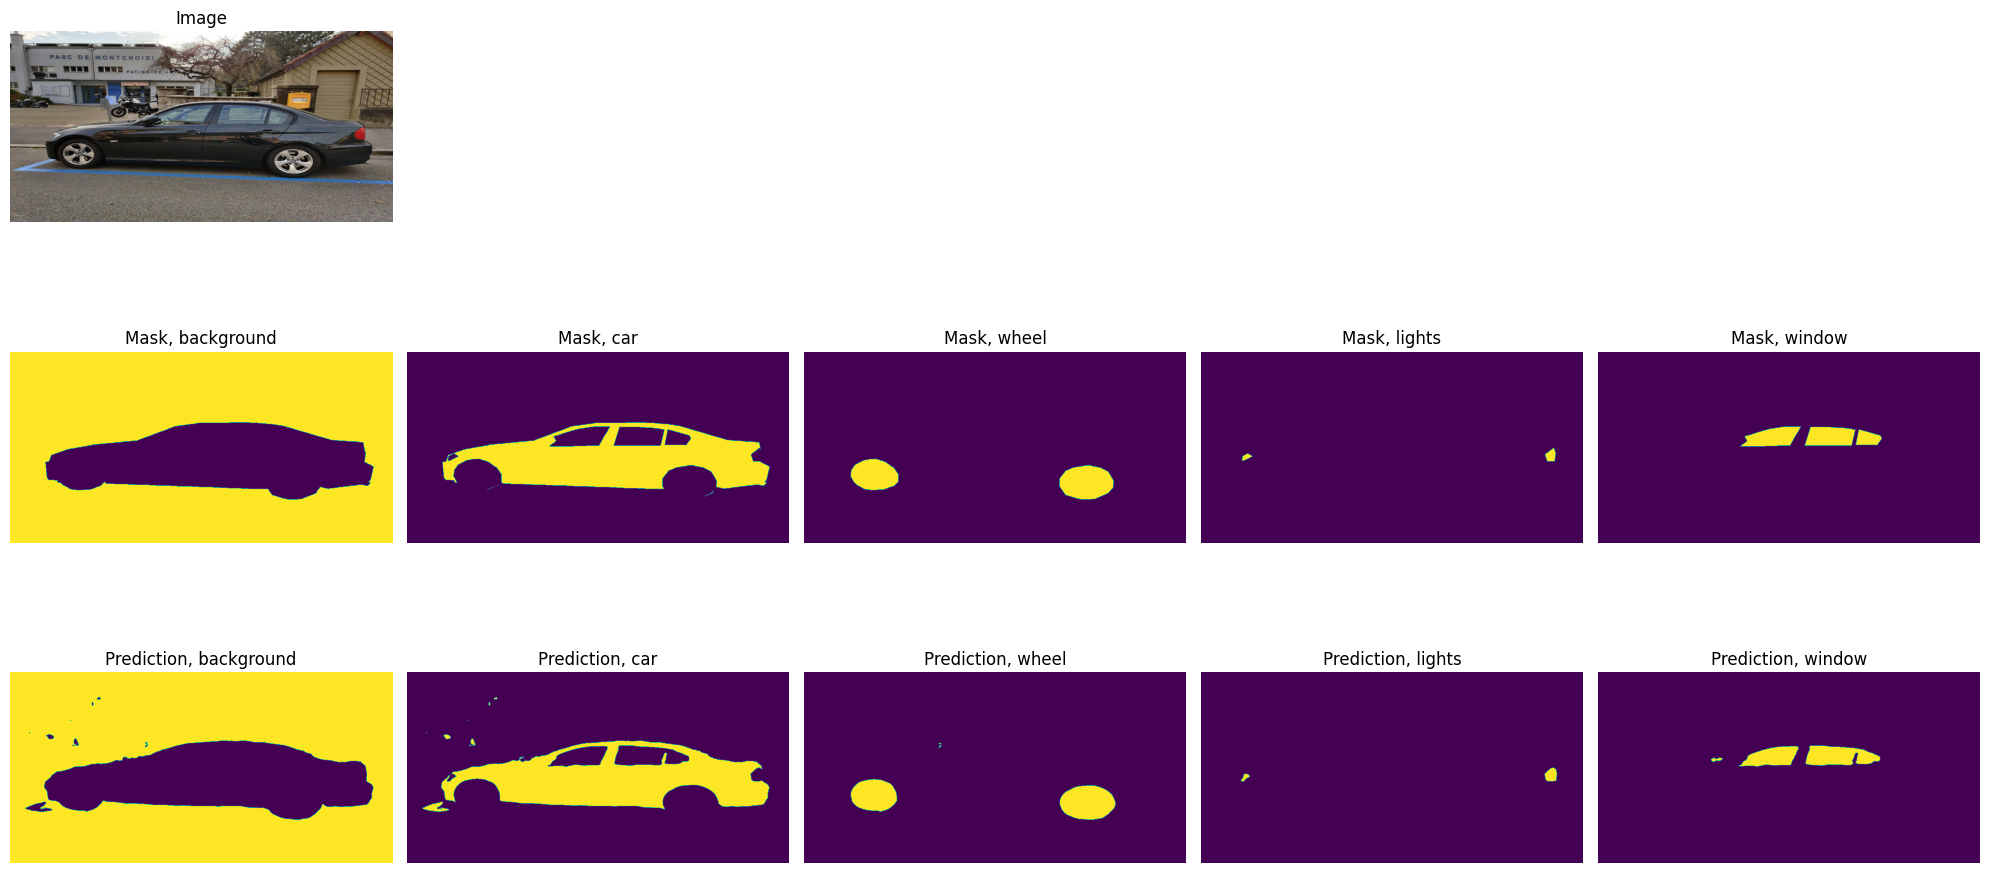

1/1 [==============================] - 0s 27ms/step


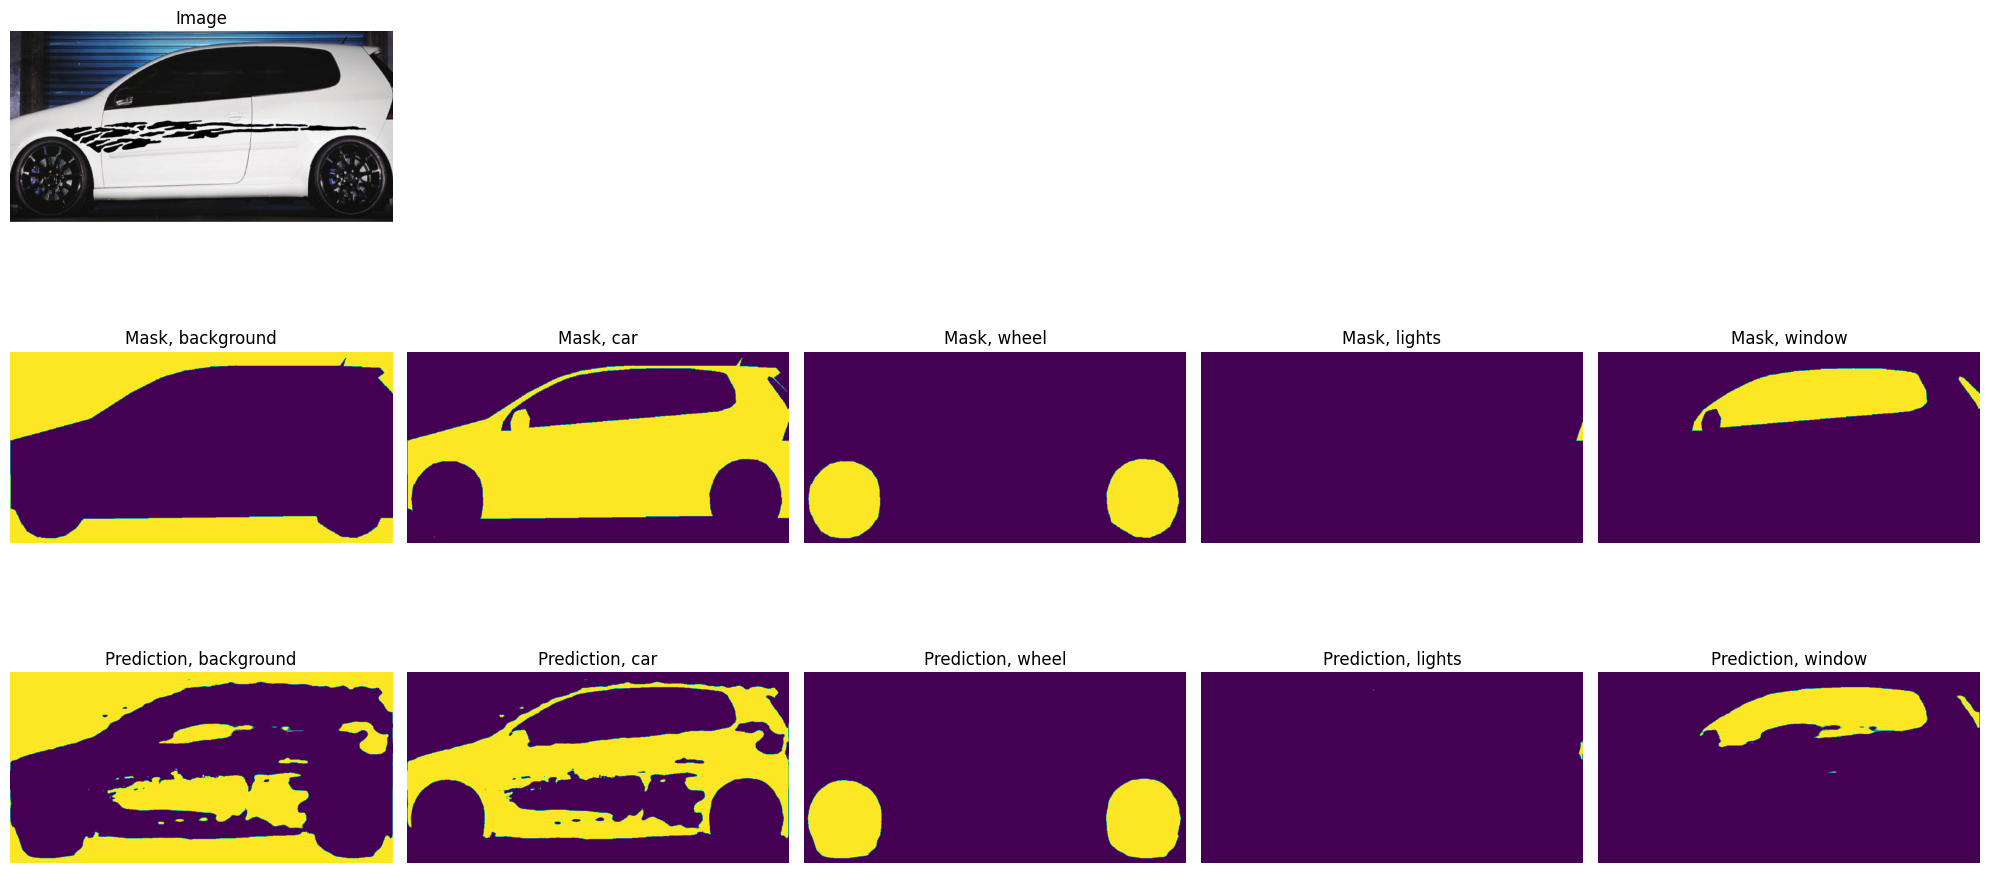

1/1 [==============================] - 0s 26ms/step


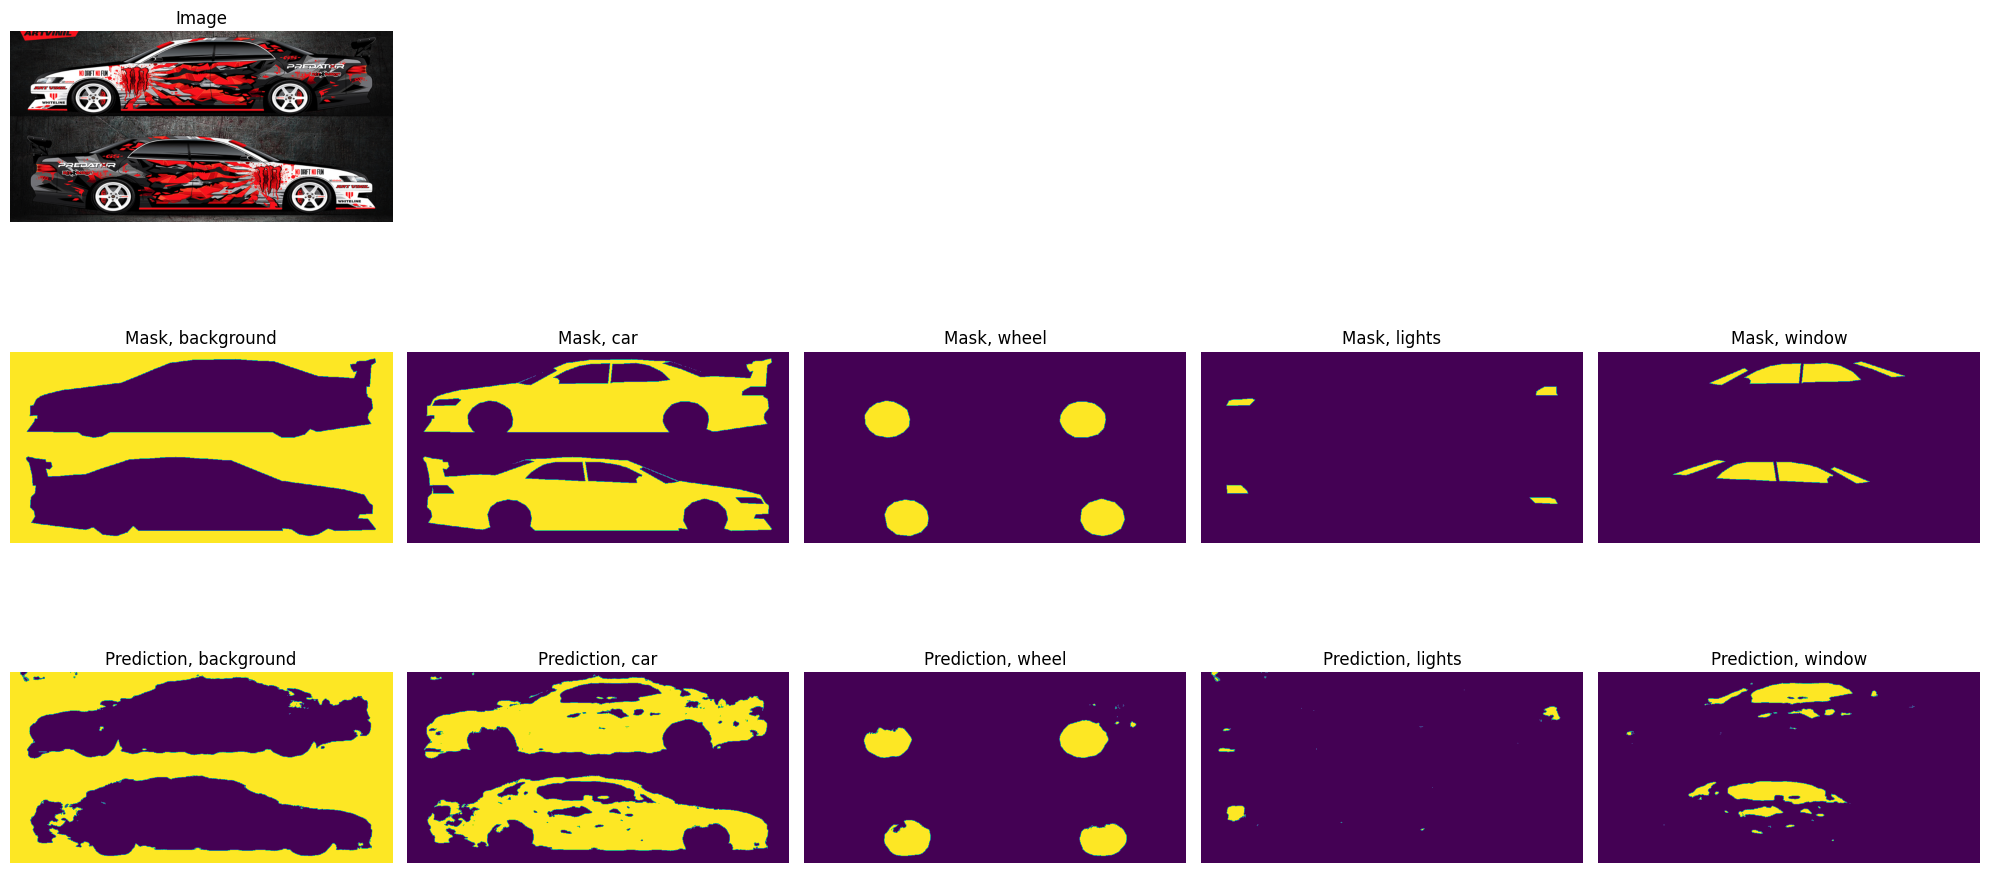

In [16]:
# test on some validation data

imageb, maskb = next(iter(val_ds))

for i in range(len(imageb)):
    image, mask = imageb[i], maskb[i]

    pred = model.predict(image[tf.newaxis, ...])[0] # (height, width, n_classes) , in probabilities
    pred = tf.math.argmax(pred, axis=-1) # (height, width) , in classes [0, 1, 2, 3, 4,...]
    pred = tf.cast(tf.one_hot(pred, depth=n_classes), tf.int64) # (height, width, n_classes) , in one hot [0, 0, 0, 0, 1], [0, 1, 0, 0, 0] ...

    plot_example(image, mask, pred)